In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(set(''.join(words)))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
block_size = 3
# words = words[:10]
def build_dataset(words):
    X , Y = [] , []
    for word in words:
        context = [0] * block_size
        for ch in word+'.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            # print(context,'----------->',idx)
            context = context[1:]+[idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X.to(device),Y.to(device)

import random

random.seed(42)
random.shuffle(words)
n1 = int( 0.8 * len(words))
n2 = int( 0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xval , Yval = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [19]:
n_embd = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(2 ** 31 -1)

C = torch.randn((vocab_size,n_embd),                generator=g , device = device)
w1 = torch.randn((n_embd * block_size,n_hidden),    generator=g , device = device) * (5 / 3) / (n_embd * block_size) ** 0.5
b1 = torch.randn((n_hidden),                        generator=g , device = device) * 0.1
w2 = torch.randn((n_hidden,vocab_size),             generator=g , device = device) * 0.01
b2 = torch.randn(vocab_size,                        generator=g , device = device) * 0

bgain = torch.ones((1,n_hidden),device = device)
bbias = torch.zeros((1,n_hidden),device = device)

bnmean_running = torch.ones((1,n_hidden), device = device)
bnstd_running = torch.zeros((1,n_hidden) , device = device)

parameters = [C,w1,b1,w2,b2,bgain,bbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12297


In [ ]:
max_steps = 200000
batch_size = 32

lossi = []

for i in range(max_steps):
    #minibatch construct

    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g,device= device)
    Xb , Yb = Xtr[ix] , Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ w1 + b1
    
    bnmeani = hpreact.mean(0,keepdim = True)
    bnstdi = hpreact.std(0,keepdim = True)

    hpreact = bgain* (hpreact -  bnmeani) / bnstdi + bbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Yb)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnmean_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps : 7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 2.0816


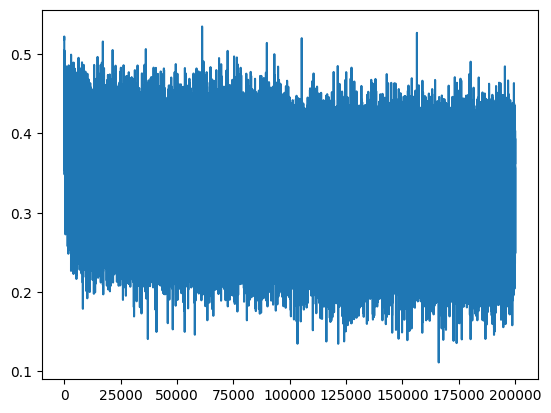

In [21]:
plt.plot(lossi)

In [31]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)

    hpreact = embcat@ w1 #+ b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [32]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : {Xtr,Ytr},
        'val' : {Xval,Yval},
        'test' : {Xte,Yte}
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ w1 + b1
    hpreact = bgain * (hpreact -  bnmean) / bnstd + bbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Yb)
    print(split,loss.item())

split_loss('train')
split_loss('val')

ValueError: Expected input batch_size (182580) to match target batch_size (32).

In [23]:
g = torch.Generator(device=device).manual_seed(2 ** 31)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh((emb.view(1,-1)) @ w1 +b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits,dim = 1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

tym.
chylardec.
ndalyvir.
nndkegnaysmikitha.
zubevrles.
brixin.
zlah.
jovinglydnazharydnuydtylarmccknydicictennvrivilahnyellaigh.
lez.
femishamirgbetd.
steguqrabellennthaslyv.
quxorycenglamurkis.
dezr.
chvst.
jucquezted.
shayr.
kedrackit.
quxil.
zymn.
chemidanvingsstighl.
